# notebook.ipynb
This is a sample notebook and web application which shows how Amazon Bedrock can be used with Neo4j. We will explore how to leverage generative AI to build and consume a knowledge graph in Neo4j.

The dataset we're using is from the SEC's EDGAR system.  It was downloaded using [these scripts](https://github.com/neo4j-partners/neo4j-sec-edgar-form13).

The dataflow in this demo consists of two parts:
1. Ingestion - we read the EDGAR files with Bedrock, extracting entities and relationships from them.  Bedrock then generates Neo4j Cypher that is run against a Neo4j database deployed from AWS Marketplace.
2. Consumption - A user inputs natural language into a web UI.  Bedrock converts that to Neo4j Cypher which is run against the database.  This flow allows non technical users to query the database.


## Setup
This notebook runs well within SageMaker.  Open your SageMaker domain.  Clone this GitHub repo.  Then open this notebook and select the SageMaker Data Science 3.0 image.

Be sure to also update the IAM policy in your user or execution role to allow access to Bedrock resources [as described here](https://github.com/aws-samples/amazon-bedrock-workshop). 

Once the permissions are in place, you'll need to run the below cell to install them in the notebook kernel.

In [ ]:
%pip install --user --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

Now we're ready to install the rest of the libraries

In [ ]:
%pip install --user "langchain==0.0.314"
%pip install --user graphdatascience
%pip install --user pydantic
%pip install --user IProgress
%pip install --user tqdm
%pip install --user gradio

Now restart the kernel.  That will allow the Python evironment to import the new packages.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

Set the service and region names.

In [ ]:
SERVICE_NAME = 'bedrock-runtime'
REGION_NAME = 'us-west-2'

In [ ]:
import boto3
import json
bedrock = boto3.client(
 service_name=SERVICE_NAME,
 region_name=REGION_NAME,
 endpoint_url=f'https://{SERVICE_NAME}.{REGION_NAME}.amazonaws.com'
)

## Prompt Definition
In the upcoming sections, we will extract knowledge adhering to the following schema. This is a very Simplified schema to extract only the information we are interested in. Normally, you will have Domain Experts who come up with an ideal Schema. Neo4j being a schema-flexible database, the schema can be modified later to accomodate new data



Schema:
````
(:Manager{name:string})-[:OWNS{reportCalendarOrQuarter:string,value:number,sshPrnamt:number,sshPrnamtType:string,investmentDiscretion:string,votingSole:number,votingShared:number,votingNone:number}]->(:Company{nameOfIssuer:string,cusip:string})
(:Manager{name:string})-[:HAS_ADDRESS]->(Address{street1:string,street2:string,city:string,stateOrCountry:string,zipCode:string})

````






To achieve our Extraction goal as per the schema, I am going to chain a series of prompts, each focused on only one task - to extract a specific entity. By this way, you can go for more granular extraction. The prompts I used here can be improved and in production scenario, you should consider running QA on the prompt pipelines to ensure that the extracted information is correct. Also, you should consider a landing and serving zones and ensure only curated data lands the serving zone.

Let's go in this order to gather the data in accordance to out data model:
1. Extract Manager Information
2. Extract Filing Information

## Data Preparation and Helper functions
Our input source is a `txt` file served from a URL. So, lets write some code to extract and convert the txt to json.

In [ ]:
import json
inp_text = ''
with open('./data/form13/raw_2023-05-15_archives_edgar_data_1027451_0000919574-23-003245.txt') as f:
    inp_text = f.read()

Now, let's write some helper functions to call Bedrock's Titan model

In [ ]:
import traceback
def call_language_model(prompt_data):
    try:
        body = json.dumps({"prompt": f"Human: {prompt_data} \n Assistant:",
                           "temperature":0,
                           "top_k":1, "top_p":0.88,
                           "anthropic_version":"bedrock-2023-05-31",
                           "max_tokens_to_sample": 2048
                          })
        modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
        accept = 'application/json'
        contentType = 'application/json'

        response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
        response_body = json.loads(response.get('body').read())

        return response_body.get('completion')
    except Exception as e:
        traceback.format_exc()
        print(e)

Now, lets define the prompts to enable our extraction process

In [ ]:
import json
import re

def extract_json_from_string(input_string):
    pattern = r'\{.*?\}|\[.*?\]'
    match = re.search(pattern, input_string.replace('\n', ' ').replace('```', ''))
    if match:
        return json.loads(match.group())

The first part of the Input text contains Manager information and the latter is filing info. 
Lets break them up to avoid LLM token limitations 

In [ ]:
parts = inp_text.split('</edgarSubmission>') #splits the text into manager details and filing details
manager_info = parts[0]
filing_info = parts[1]

Sometimes `filing_info` can be larger text beyond the limits of LLM input length. So, lets split that up to chunks

In [ ]:
import numpy as np
import re
def split_filing_info(s):
    pattern = '(</(\w+:)?infoTable>)'
    splitter = re.findall(pattern, s)[0][0]
    _parts = s.split(splitter)
    if len(_parts) > 15:
        chunks_of_list = np.array_split(_parts, len(_parts)/15) # max 15 filings per part
        chunks_of_str = map(lambda x: splitter.join(x), chunks_of_list)
        return list(chunks_of_str)
    else:
        return [s]

filing_info_chunks = split_filing_info(filing_info)
len(filing_info_chunks)

## Extract Manager info

In [ ]:
mgr_info_tpl="""From the text below, extract the following as json. Do not miss any of these information.
* The tags mentioned below may or may not namespaced. So extract accordingly. Eg: <ns1:tag> is equal to <tag>
* "name" - The name from the <name> tag under <filingManager> tag
* "street1" - The manager's street1 address from the <com:street1> tag under <address> tag
* "street2" - The manager's street2 address from the <com:street2> tag under <address> tag
* "city" - The manager's city address from the <com:city> tag under <address> tag
* "stateOrCountry" - The manager's stateOrCountry address from the <com:stateOrCountry> tag under <address> tag
* "zipCode" - The manager's zipCode from the <com:zipCode> tag under <address> tag
* "reportCalendarOrQuarter" - The reportCalendarOrQuarter from the <reportCalendarOrQuarter> tag under <address> tag
* Just return me the JSON enclosed by 3 backticks. No other text in the response

Text:
$ctext
"""

In [ ]:
from string import Template
import json
prompt = Template(mgr_info_tpl).substitute(ctext=manager_info)
manager_info = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
manager_info

## Extract Filing Information

In [ ]:
filing_info_tpl = """From the text below, extract the following as a list of json enclosed by 3 back ticks. You will find many filing information under the <infoTable> tag. Extract all of them.
* "nameOfIssuer" - The name from the <nameOfIssuer> tag under <infoTable> tag
* "cusip" - The cusip from the <cusip> tag under <infoTable> tag
* "value" - The value from the <value> tag under <infoTable> tag
* "sshPrnamt" - The sshPrnamt from the <sshPrnamt> tag under <infoTable> tag
* "sshPrnamtType" - The sshPrnamtType from the <sshPrnamtType> tag under <infoTable> tag
* "investmentDiscretion" - The investmentDiscretion from the <investmentDiscretion> tag under <infoTable> tag
* "votingSole" - The votingSole from the <votingSole> tag under <infoTable> tag
* "votingShared" - The votingShared from the <votingShared> tag under <infoTable> tag
* "votingNone" - The votingNone from the <votingNone> tag under <infoTable> tag

Text:
$ctext
"""

In [ ]:
filings = []
for chunk in filing_info_chunks:
    prompt = Template(filing_info_tpl).substitute(ctext=chunk)
    response = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
    filings = filings + response

len(filings)

## Data Ingestion Cypher Generation

The entities and relationships we got from the LLM have to be transformed to Cypher so we can write them into Neo4j.

In [ ]:
import re

def get_cypher_compliant_var(_id):
    s = re.sub(r'[\W_]', '', _id).lower() #avoid numbers appearing as firstchar; replace spaces
    return s[:20] #restrict variable size

def generate_cypher(manager, filings):
    cyphers = []
    create_manager = f'MERGE (mgr:Manager{{name: "{manager["name"]}"}})'
    cyphers.append(create_manager)
    
    addr_id = get_cypher_compliant_var(manager["name"])
    create_address = f'''MERGE (addr:Address{{id: "{addr_id}"}})
    ON CREATE SET addr.street1 = "{manager["street1"]}",
    addr.street2 = "{manager["street2"]}",
    addr.city = "{manager["city"]}",
    addr.stateOrCountry = "{manager["stateOrCountry"]}",
    addr.zipCode = "{manager["zipCode"]}"
    '''
    cyphers.append(create_address)
    
    relate_mgr_addr = f'''MATCH (mgr:Manager{{name: "{manager["name"]}"}})
      MATCH (addr:Address{{id: "{addr_id}"}})
      MERGE (mgr)-[:HAS_ADDRESS]->(addr)'''
    cyphers.append(relate_mgr_addr)
    
    for f in filings:
        create_company = f'''MERGE (co:Company{{cusip: "{f['cusip']}"}}) 
        ON CREATE SET co.nameOfIssuer = "{f["nameOfIssuer"]}"'''
        cyphers.append(create_company)
        
        on_create_set = f"""o.reportCalendarOrQuarter = "{manager['reportCalendarOrQuarter']}",
               o.value = {float(f.get('value', 0))},
               o.sshPrnamt = {float(f.get('sshPrnamt', 0))},
               o.sshPrnamtType = "{f.get('sshPrnamtType', '')}",
               o.investmentDiscretion = "{f.get('investmentDiscretion', '')}",
               o.votingSole = {int(f.get('votingSole', '0'))},
               o.votingShared = {int(f.get('votingShared', '0'))},
               o.votingNone = {int(f.get('votingNone', '0'))}"""
        on_merge_set = f"""o.value = o.value + {float(f.get('value', 0))},
               o.sshPrnamt = o.sshPrnamt + {float(f.get('sshPrnamt', 0))},
               o.votingSole = o.votingSole + {int(f.get('votingSole', '0'))},
               o.votingShared = o.votingShared + {int(f.get('votingShared', '0'))},
               o.votingNone = o.votingNone + {int(f.get('votingNone', '0'))}"""
        relate_mgr_co = f'''MATCH (mgr:Manager{{name: "{manager["name"]}"}})
          MATCH (co:Company{{cusip: "{f['cusip']}"}})
          MERGE (mgr)-[o:OWNS]->(co)
          ON CREATE SET {on_create_set}
          ON MATCH SET {on_merge_set}
          '''
        cyphers.append(relate_mgr_co)
        
    return cyphers
         

In [ ]:
ingestion_cypher = generate_cypher(manager_info, filings)
len(ingestion_cypher)

## Data Ingestion
You will need a Neo4j instance.  You can deploy that on AWS Marketplace [here](https://aws.amazon.com/marketplace/pp/prodview-akmzjikgawgn4).  Be sure to deploy a single node and select GDS.  We're going to need the GDS libraries available.

With that complete, you'll need to install the Neo4j library and set up your database connection.

In [ ]:
from graphdatascience import GraphDataScience

# username is neo4j by default
username = 'neo4j'

# You will need to change these variables
connectionUrl = 'neo4j+s://a74f499e.databases.neo4j.io'
password = 'Kn5Fg93io_7nv1a1uofVed6-gTxvaFaQrKozE03S_YQ'

In [ ]:
gds = GraphDataScience(
    connectionUrl,
    auth=(username, password),
    )

gds.set_database("neo4j")

Before loading the data, create constraints as below

In [ ]:
gds.run_cypher('CREATE CONSTRAINT unique_manager IF NOT EXISTS FOR (n:Manager) REQUIRE (n.name) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_address_id IF NOT EXISTS FOR (n:Address) REQUIRE (n.id) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_company_id IF NOT EXISTS FOR (n:Company) REQUIRE (n.cusip) IS UNIQUE')

In [ ]:
%%time
from tqdm import tqdm
for e in tqdm(ingestion_cypher):
    gds.run_cypher(e)

Your ingested data from the above commands might look like this:
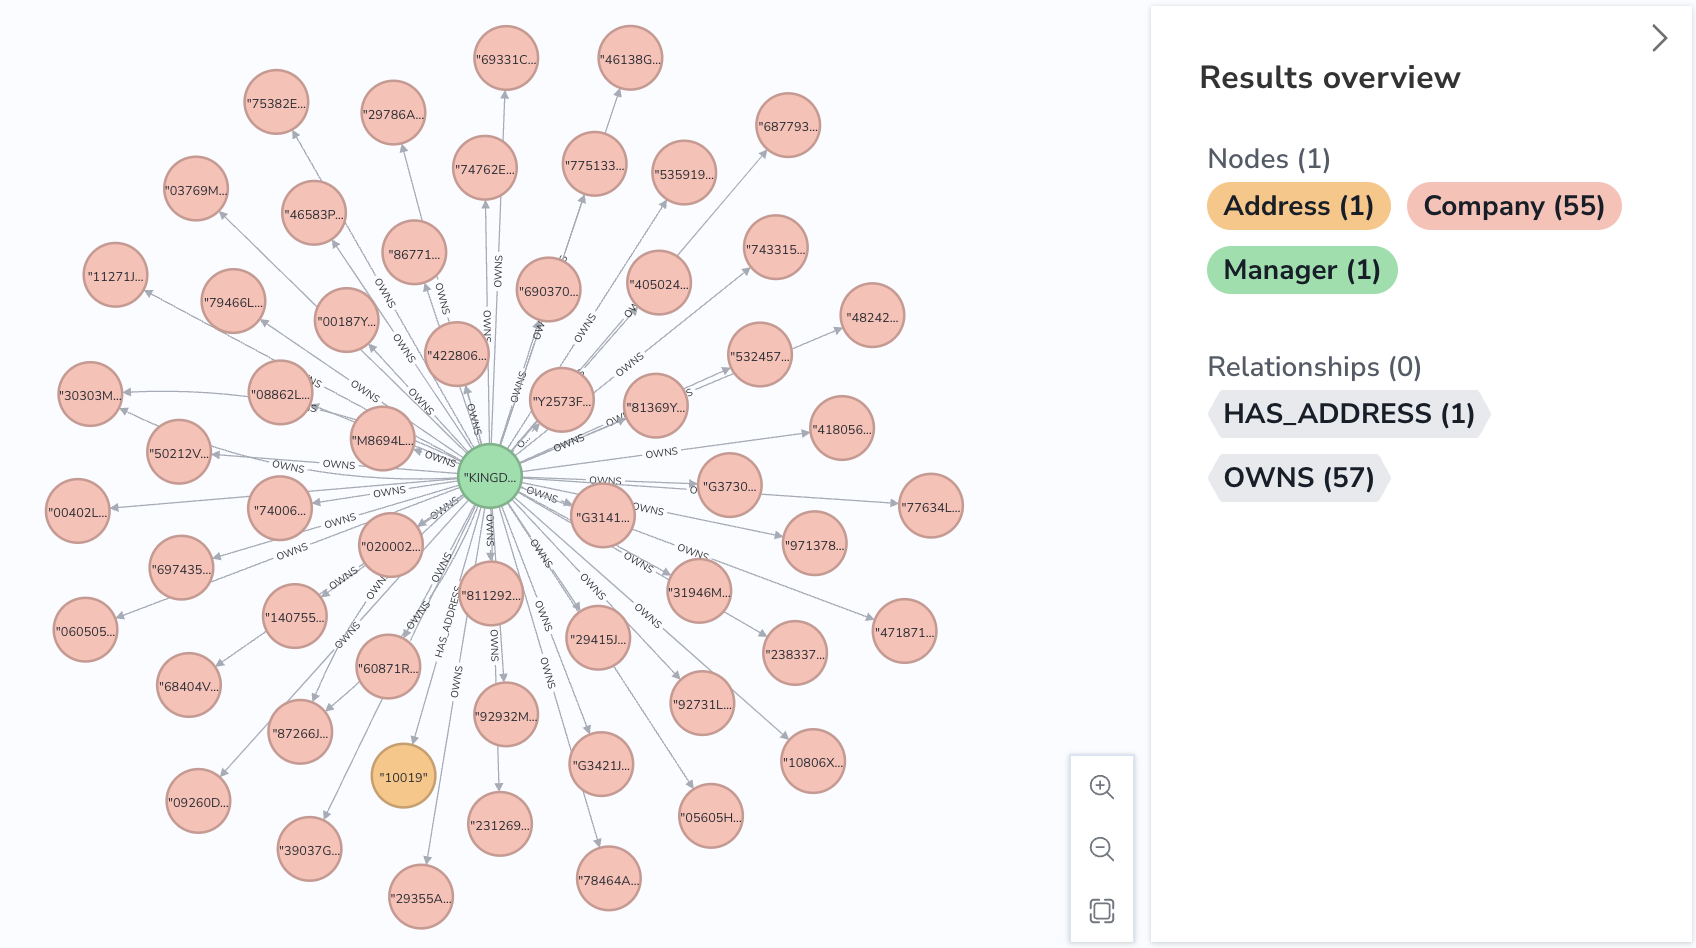

Lets feed the pipeline of EDGAR files, feed to the LLM and ingest to Neo4j

In [ ]:
import glob
from string import Template
import json
from pathlib import Path
from tqdm import tqdm

def run_pipeline(start=0, count=1):
    txt_files = glob.glob("data/form13/*.txt")[start:count]
    print(f"Running pipeline for {len(txt_files)} files")
    failed_files = process_pipeline(txt_files)
    print(failed_files)
    return failed_files

def process_pipeline(files):
    failed_files = []
    i = 0
    for f in files:
        i += 1
        try:
            with open(f, 'r', encoding='utf-8', errors='ignore') as file:
                print(f"  {f}: Reading File No. ({i})")
                data = file.read().rstrip()
                text = data
                print(f"    {f}: Extracting Entities & Relationships")
                manager, filings = run_extraction(f, text)
                print(f"    {f}: Generating Cypher")
                cyphers = generate_cypher(manager, filings)
                print(f"    {f}: Ingesting Data")
                for e in tqdm(cyphers, desc="Ingesting Data"):
                    gds.run_cypher(e)
                print(f"    {f}: Processing DONE")
        except Exception as e:
            print(f"    {f}: Processing Failed with exception {e}")
            failed_files.append(f)
    return failed_files

import numpy as np
def split_filing_info(s):
    pattern = '(</(\w+:)?infoTable>)'
    splitter = re.findall(pattern, s)[0][0]
    _parts = s.split(splitter)
    if len(_parts) > 15:
        chunks_of_list = np.array_split(_parts, len(_parts)/15) # max 15 filings per part
        chunks_of_str = map(lambda x: splitter.join(x), chunks_of_list)
        return list(chunks_of_str)
    else:
        return [s]
        
from timeit import default_timer as timer
def run_extraction(f, text):
    start = timer()
    
    parts = text.split('</edgarSubmission>') #splits the text into manager details and filing details
    manager_info = parts[0]
    filing_info = parts[1]
    
    prompt = Template(mgr_info_tpl).substitute(ctext=manager_info)
    manager = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
    
    filing_info_chunks = split_filing_info(filing_info)
    filings = []
    for chunk in filing_info_chunks:
        prompt = Template(filing_info_tpl).substitute(ctext=chunk)
        response = json.loads(call_language_model(prompt).split('```')[1].strip('json'))
        filings = filings + response 
    print(f"    {f}: Total Filings: {len(filings)}")
    end = timer()
    elapsed = (end-start)
    print(f"    {f}: Entity Extraction took {elapsed}secs")
    return (manager, filings)

In [ ]:
%%time
failed_files = run_pipeline(0, 5) # runs ingestion pipeline for files from index 0 to 5

In [ ]:
with open('./failed_files.json', 'w') as f:
    f.write(json.dumps(failed_files))

## Ingest Form 10 reports as Vector Embeddings
### 10-K Filings Exploration and Chunking
Let's open one file to understand its contents. It is actually a json file.

In [ ]:
import json
with open('./data/form10k/0001830197-22-000038.txt') as f:
    f10_k = json.load(f)

We are interested in Item 1 specifically.

Item 1 describes the business of the company: who and what the company does, what subsidiaries it owns, and what markets it operates in. It may also include recent events, competition, regulations, and labor issues. (Some industries are heavily regulated, and have complex labor requirements, which have significant effects on the business.) Other topics in this section may include special operating costs, seasonal factors, or insurance matters.

In [ ]:
len(f10_k['item1'])

This text has the ability to exceed token limits for `amazon.titan-embed-text-v1`. Also the quality of embeddings can go down if the text gets to large. As such we should find some way to chunk the text up into seperate sections for embedding.

Below is a way to do this with Langchain's RecursiveCharacterTextSplitter which takes into account of Chunk overlaps.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text = f10_k['item1']

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap  = 15,
    length_function = len,
    is_separator_regex = False,
)
docs = text_splitter.split_text(text)
print(docs[0])


### Get 10-K Text Embeddings with Bedrock
Now that we understand our data and how to chunk it. Let's Generate embeddings.


In [ ]:
from langchain.embeddings import BedrockEmbeddings
EMBEDDING_MODEL = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrock)

In [ ]:
# We will need a chunking utility to stay within token limits as we loop through files
def chunks(xs, n=3):
    n = max(1, n)
    return [xs[i:i + n] for i in range(0, len(xs), n)]

In [ ]:
import time

def create_text_embedding_entries(input_text:str, company_name: str, cusip: str):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 2000,
        chunk_overlap  = 15,
        length_function = len,
        is_separator_regex = False,
    )
    docs = text_splitter.split_text(input_text)
    res = []
    seq_id = -1
    for d in chunks(docs):
        embeddings = EMBEDDING_MODEL.embed_documents(d)
        
        for i in range(len(d)):
            seq_id += 1
            res.append({'companyName': company_name, 'cusip': cusip, 'seqId': seq_id, 'contextId': company_name + str(seq_id), 'textEmbedding': embeddings[i], 'text': d[i]})
    return res

In [ ]:
import os

file_names = os.listdir('./data/form10k/')
len(file_names)

In [ ]:
%%time

count = 0
embedding_entries = []
for file_name in file_names:
    if '.txt' in file_name:
        count += 1
        if count % 5 == 0:
            print(f'Parsed {count} of {len(file_names)}')
        with open('./data/form10k/' + file_name) as f:
            f10_k = json.load(f)
        embedding_entries.extend(create_text_embedding_entries(f10_k['item1'], f10_k['companyName'], f10_k['cusip']))
len(embedding_entries)

## Save 10-K Documents with Embeddings
We will save these locally to use in graph loading, in the next part.



In [ ]:
import pandas as pd
edf = pd.DataFrame(embedding_entries)
edf

In [ ]:
gds.run_cypher('CREATE INDEX company_name IF NOT EXISTS FOR (n:Company) ON (n.companyName)')
gds.run_cypher('CREATE CONSTRAINT unique_document_id IF NOT EXISTS FOR (n:Document) REQUIRE (n.documentId) IS NODE KEY')

Due to the size of the documents we will want to transform the dataframe into a list of dict that we can chunk up and insert via parameterized query.

In [ ]:
emb_entries = edf.to_dict(orient='records')
total = len(emb_entries)
count = 0
for d in chunks(emb_entries, 100):
    gds.run_cypher('''
    UNWIND $records AS record
    MATCH(c:Company {cusip:record.cusip})
    MERGE(b:Document {documentId:record.contextId})
    SET b.documentType = 'FORM_10K_ITEM1', b.seqId = record.seqId, b.textEmbedding = record.textEmbedding, b.text = record.text
    MERGE(c)-[:HAS]->(b)
    RETURN count(b) as cnt
    ''', params = {'records':d})
    count += len(d)
    print(f'loaded {count} of {total}')

### Check Data

In [ ]:
gds.run_cypher('MATCH(doc:Document) RETURN count(doc)')

Note that we were only getting 10-K docs for a minority of companies. It should be fine for this, but in a more rigorous setting, you may want to try and pull more. There are likely a few factors attributing to this.

1. We used company names to search EDGAR which resulted in many misses and dups which were discarded. In a more rigorous setting, we would investigate other endpoints and use more parsing to extract EDGAR cik keys for exact matching companies when pulling forms.

1. Company names are not consistent across form13 filings, so even if we successfully pull on one version of a company name, we may not be able to merge it into the graph via the one company name represented there.

1. Not all companies in the dataset are obligated to file 10-Ks.

In [ ]:
# Check count and percentage of companies with 10-K docs.  Note it is the minority
gds.run_cypher('''
MATCH(b:Company)
WITH b, count{(b)-[:HAS]->(d:Document)} AS docCount
WITH count(b) AS total, sum(toInteger(docCount > 0)) AS numWithDocs
RETURN total, numWithDocs, round(100*toFloat(numWithDocs)/toFloat(total), 2) As PercWithDocs
''')

## Neo4j Vector Index
We will need to create a vector index for similarity search on Document nodes. Neo4j offers a vector index that enables Approximate Nearest Neighbor Search (ANN). Let's creat an index.

In [ ]:
gds.run_cypher("CALL db.index.vector.createNodeIndex('document-embeddings', 'Document', 'textEmbedding', 1536, 'cosine')")

You can see that vector index has been created using `SHOW INDEXES`

In [ ]:
gds.run_cypher(''' 
SHOW INDEXES YIELD name, type, labelsOrTypes, properties, options
WHERE type = "VECTOR"
''')

## Retrieval Augmented Generation (RAG) using Vector

In [ ]:
from langchain.llms.bedrock import Bedrock
bedrock_llm = Bedrock(
    model_id="anthropic.claude-v2",
    client=bedrock,
    model_kwargs = {
        "temperature":0,
        "top_k":1, "top_p":0.1,
        "anthropic_version":"bedrock-2023-05-31",
        "max_tokens_to_sample": 2048
    }
)
query = "Which company sells Procore Analytics?"

### RAG using only Vector Embeddings

In [ ]:
def vector_only_qa(query):
    query_vector = EMBEDDING_MODEL.embed_query(query)
    return gds.run_cypher("""
    CALL db.index.vector.queryNodes('document-embeddings', 50, $queryVector)
    YIELD node AS doc, score
    RETURN doc.text as text, avg(score) AS score
    ORDER BY score DESC LIMIT 50
    """, params =  {'queryVector': query_vector})

In [ ]:
from json import loads, dumps
def df_to_context(df):
    result = df.to_json(orient="records")
    parsed = loads(result)
    return dumps(parsed)
    

In [ ]:
from langchain.prompts import PromptTemplate

def answer_from_context(query, context):
    prompt = PromptTemplate(input_variables=["input", "context"],
                               template = """Human: You are a Financial expert with SEC filings. 
Answer the question based on the context provided in JSON below. Think step by step before answering.

<question>
{input}
</question>

Here is the context:
<context>
{context}
</context>

Assistant:
""")
    conversation = prompt.format(input=query, context=context)
    return bedrock_llm(conversation)

In [ ]:
def rag_vector_only(query):
    df = vector_only_qa(query)
    ctx = df_to_context(df)
    return answer_from_context(query, ctx)

In [ ]:
rag_vector_only(query)

As seen above, the model guessed Procore Technologies and name is not fully correct. Lets see how Vector + Graph approach performs here

### RAG with Vectors + Knowledge Graph -> More Context

In [ ]:
def vector_graph_qa(query):
    query_vector = EMBEDDING_MODEL.embed_query(query)
    return gds.run_cypher("""
    CALL db.index.vector.queryNodes('document-embeddings', 50, $queryVector)
    YIELD node AS doc, score
    OPTIONAL MATCH (doc)<-[:HAS]-(company:Company), (company)<-[:OWNS]-(manager:Manager)
    RETURN company.nameOfIssuer AS companyName, doc.text as text, manager.name as asset_manager, avg(score) AS score
    ORDER BY score DESC LIMIT 50
    """, params =  {'queryVector': query_vector})

In [ ]:
def rag_vector_and_graph(query):
    df = vector_graph_qa(query)
    ctx = df_to_context(df)
    return answer_from_context(query, ctx)

In [ ]:
rag_vector_and_graph(query)

### More Comparisons

In [ ]:
query = 'Name the managers are exposed to investments in regulated companies?'
print(rag_vector_only(query))
print(rag_vector_and_graph(query))

## Retrieval Augmented Generation (RAG) using Cypher

### Generate Cypher
Both Bedrock and Neo4j support LangChain.  We will be using LangChain to quickly convert English to Cypher and then executes it on Neo4j.  This is augmented using generative AI before sending the response to the user.  This makes graph consumption easier for non-cypher experts.

The diagram below shows how Neo4j and Bedrock will interact using LangChain.

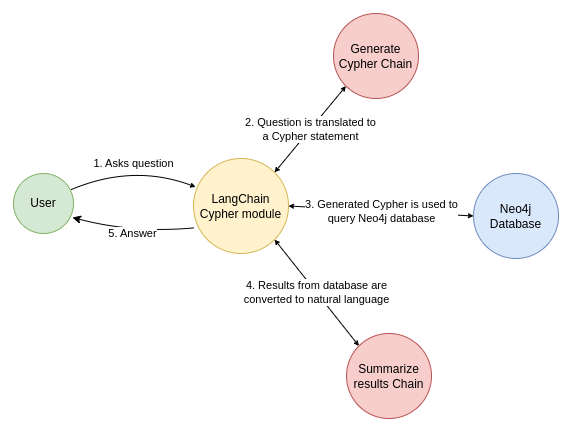

First we have to create Neo4jGraph and Bedrock Connection objects.

In [ ]:
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph
from langchain.llms.bedrock import Bedrock
from langchain.prompts.prompt import PromptTemplate

CYPHER_GENERATION_TEMPLATE = """Human: You are an expert Neo4j Cypher translator who understands the question in english and convert to Cypher strictly based on the Neo4j Schema provided and following the instructions below:
1. Generate Cypher query compatible ONLY for Neo4j Version 5
2. Do not use EXISTS, SIZE keywords in the cypher. Use alias when using the WITH keyword
3. Use only Nodes and relationships mentioned in the schema
4. Always enclose the Cypher output inside 3 backticks
5. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Company name use `toLower(c.name) contains 'neo4j'`
6. Always use aliases to refer the node in the query
7. Cypher is NOT SQL. So, do not mix and match the syntaxes
Strictly use this Schema for CYpher generation:
{schema}
Human: {question}
Assistant:
"""
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

graph = Neo4jGraph(
    url=connectionUrl, 
    username='neo4j', 
    password=password
)
bedrock_llm = Bedrock(
                model_id="anthropic.claude-v2",
                client=bedrock,
                model_kwargs = {
                    "temperature":0,
                    "top_k":1, "top_p":0.1,
                    "anthropic_version":"bedrock-2023-05-31",
                    "max_tokens_to_sample": 2048
                }
            )
chain = GraphCypherQAChain.from_llm(
            bedrock_llm, graph=graph, verbose=True,
            cypher_prompt=CYPHER_GENERATION_PROMPT,
    return_direct=True
)
def summarise_results(result_json):
    summary_prompt_tpl = f"""Human: 
    Fact: {json.dumps(r['result'])}

    * Summarise the above fact as if you are answering this question "{r['query']}"
    * When the fact is not empty, assume the question is valid and the answer is true
    * Do not return helpful or extra text or apologies
    * Just return summary to the user. DO NOT start with Here is a summary
    * List the results in rich text format if there are more than one results
    Assistant:
    """
    return bedrock_llm(summary_prompt_tpl)

In [ ]:
r = chain("""Which managers own Amazon?""")
summarise_results(r)

In [ ]:
r = chain("""If a Manager own Amazon, do they also own Meta?""")
summarise_results(r)

## Chatbot
Now we are going to use Gradio to deploy a chat interface that will have our chain behind it.

When we run the code below, a Gradio application will be deployed and can be accessed at a local URL. We also get a public URL that can be shared for 3 days.

In [ ]:
import gradio as gr
import typing_extensions
from langchain.memory import ConversationBufferMemory

def chat_response(input_text, history):
    try:
        r = chain(input_text)
        return summarise_results(r)
    except:
        return "I'm sorry, there was an error retrieving the information you requested."

interface = gr.ChatInterface(fn = chat_response,
                             title = "Investment Chatbot",
                             description = "powered by Neo4j",
                             theme = "soft",
                             chatbot = gr.Chatbot(height=500),
                             undo_btn = None,
                             clear_btn = "\U0001F5D1 Clear chat",
                             examples = ["Who are Tesla's top investors in last 3 months?",
                                         "What are the top 10 investments for Blackrock?",
                                         "Which manager owns FAANG stocks?",
                                         "What are other top investments for fund managers investing in Exxon?",
                                         "What are Vanguard's top investments by value for 2023?",
                                         "Who are the common investors between Tesla and Microsoft?"])

interface.launch(share=True)